# **Analyse et Prédiction du Risque de Crédit**

Dans le climat économique actuel, l'analyse du risque de crédit est plus pertinente que jamais. Les institutions financières sont continuellement confrontées au défi de distinguer les bons emprunteurs des mauvais pour minimiser les pertes tout en maximisant les opportunités de revenus.

**Objectif** :

L'objectif de ce projet était de développer un modèle prédictif capable de classer les statuts de compte courant des clients en "bon" ou "mauvais" en fonction de leur risque de crédit. En utilisant un ensemble de données comprenant 1000 clients.  nous avons appliqué plusieurs techniques de modélisation statistique, dont la Régression Logistique et XGBoost, pour prédire le risque.


**Impact Attendu**

Le résultat de ce projet a le potentiel de transformer significativement la façon dont les prêteurs évaluent les risques, en réduisant les pertes dues aux défaillances de crédit et en optimisant les processus de décision de prêt.

**Approche et Méthodologie**

Nous avons commencé par une analyse exploratoire des données pour comprendre les caractéristiques et les tendances. Nous avons ensuite prétraité les données, appliqué des techniques de rééquilibrage comme SMOTE pour gérer les déséquilibres des classes, et finalement, mis en œuvre et optimisé plusieurs modèles de machine learning.


In [ ]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

warnings.filterwarnings('ignore')


# I-  **ANALYSE EXPLORATOIRE DES DONNEES**

1- **Les données**

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Data/Credit_cleaned.json', lines=True)
df.head(4)

,Durations,Credit history,Credit_Purpose,Credit amount,Installment_Rate_Percent,Other debtors / guarantors,Residence_Years,Property,Age in years,Other_Inst_Plans,...,Num_Existing_Credits,Job,Liable_People,Telephone,Foreign worker,Checking_Account_Status,Gender,Status,Years_Employments,Saving_Status
0,6,critical/other existing credit,radio/tv,1169,4,none,4,real estate,67,none,...,2,skilled,1,yes,yes,good,male,single,7 or more years,no savings
1,48,existing paid,radio/tv,5951,2,none,2,real estate,22,none,...,1,skilled,1,none,yes,bad,female,div/dep/mar,1-3 years,less than 100
2,12,critical/other existing credit,education,2096,2,none,3,real estate,49,none,...,1,unskilled_resident,2,none,yes,good,male,single,4-6 years,less than 100
3,42,existing paid,furniture/equipment,7882,2,guarantor,4,life insurance,45,none,...,1,skilled,2,none,yes,good,male,single,4-6 years,less than 100


In [ ]:
#df.info()

Notre dataset contient 1000 observations et 21 variables, avec :

- 7 variables numériques (Durations, Credit amount, Age in years...).
- 14 variables catégorielles (Credit history, Property, Gender...).
- 1 variable cible probable (Checking_Account_Status )

- **les valeurs manquantes**

In [ ]:
df.isnull().sum().to_frame().T


,Durations,Credit history,Credit_Purpose,Credit amount,Installment_Rate_Percent,Other debtors / guarantors,Residence_Years,Property,Age in years,Other_Inst_Plans,...,Num_Existing_Credits,Job,Liable_People,Telephone,Foreign worker,Checking_Account_Status,Gender,Status,Years_Employments,Saving_Status
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Notre base de données est complète, sans valeurs manquantes.

In [ ]:
#df.nunique()

### **Statistiques et visualisation des données**

### 1- Les variables Numeriques

In [ ]:
df.describe()

,Durations,Credit amount,Installment_Rate_Percent,Residence_Years,Age in years,Num_Existing_Credits,Liable_People
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


- **Durations**:  La durée du credit est en moyenne de 21 mois ce qui indique que la majorité des crédits ont une durée inférieure à 2 ans.
- **Credit amount**: Le montant du crédit est en moyenne de **3271**. Le montant minimum est de **250**, tandis que le montant maximal atteint **18 424**. La médiane est de **2 319**, ce qui signifie que la moitié des crédits accordés sont inférieurs à ce montant, tandis que l'autre moitié est supérieure.
- **Installment_Rate_Percent**: Le taux d'écheance en % du revenu est en moyenne de 2,97 % et un écart-type de 1,12 qui traduit une faible variabilité du taux.
La majorité des crédits  ont un taux entre 2% et 4%, ce qui pourrait signifier un seuil réglementaire ou une politique de prêt standardisée.
- **Residence_Years**: La mojorité des emprunteurs résident depuis 2 ou 4ans à la même adresse, indiquant un critère de stabilité financière.
- **Age in years**: L'âge moyen d'un emprunteur est de **35**ans, avec l'âge minimum est de 19ans tandis que l'âge maximum est de 75ans. Les emprunteurs sont principalement des aldultes d'âge moyen, mais l'étendue va de jeunes à des seniors.
- **Num_Existing_Credits**: Le nombre de crédits existants est en moyen de 1,4. La plupart des clients ont 1 ou 2 creédits en cours.

- **Liable_People**: (Personnes à charge) La majorité des emprunteurs ont Une (1) personne à charge, avec un maximum de 2.

En somme:

Crédits majoritairement courts (≤ 2 ans) mais avec quelques prêts longs (jusqu'à 6 ans).

Montants très variables avec une asymétrie probable due aux valeurs élevées.

Taux d’échéance relativement stable (entre 2% et 4% du revenu).
Clients généralement jeunes ou d’âge moyen (19 à 75 ans, avec une médiane autour de 33 ans).

Peu de crédits existants simultanément (généralement 1 ou 2).

Stabilité de résidence relativement courte (≤ 4 ans en moyenne).
Peu de personnes à charge (1 ou 2 max).

### - **Distribution des variables**

## **Analyse Univarié**

### 1- Les variables numériques

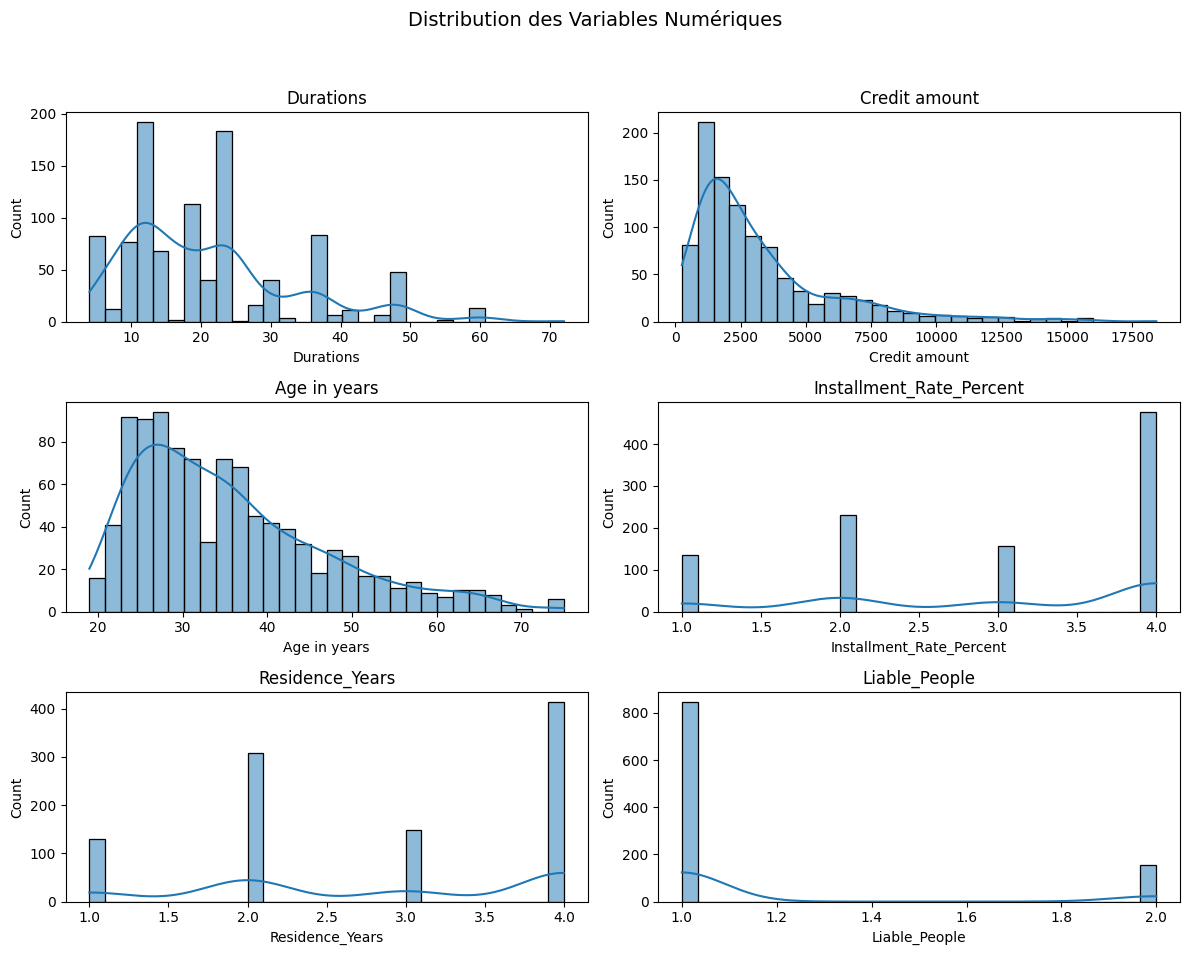

In [ ]:
# Visualisation des distributions des variables numériques
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle("Distribution des Variables Numériques", fontsize=14)

num_vars = ["Durations", "Credit amount", "Age in years", "Installment_Rate_Percent", "Residence_Years", "Liable_People"]
for i, var in enumerate(num_vars):
    sns.histplot(df[var], bins=30, kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(var)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 2- Les variables catégorielles

In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Afficher la liste des colonnes catégorielles
print(categorical_columns)

Index(['Credit history', 'Credit_Purpose', 'Other debtors / guarantors',
       'Property', 'Other_Inst_Plans', 'Housing', 'Job', 'Telephone',
       'Foreign worker', 'Checking_Account_Status', 'Gender', 'Status',
       'Years_Employments', 'Saving_Status'],
      dtype='object')


- **Checking_Account_Status**

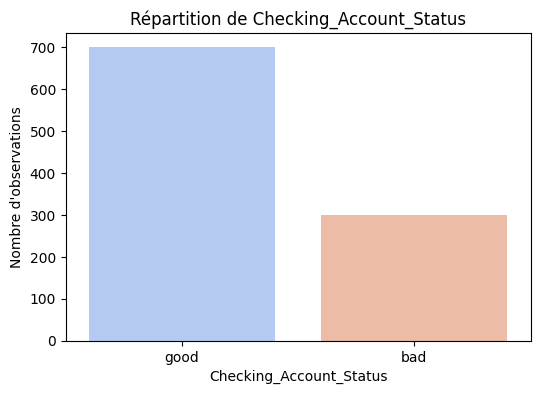

In [ ]:
# Distribution de la variable cible "Checking_Account_Status"
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Checking_Account_Status"], palette="coolwarm")
plt.title("Répartition de Checking_Account_Status")
plt.xlabel("Checking_Account_Status")
plt.ylabel("Nombre d'observations")
plt.show()


- Il semble y avoir plus de clients "Good" que de clients "Bad".
- Cela signifie que notre dataset est légèrement déséquilibré, ce qui peut affecter la performance du modèle.

**- Distribution des autres variables catégorielles.**

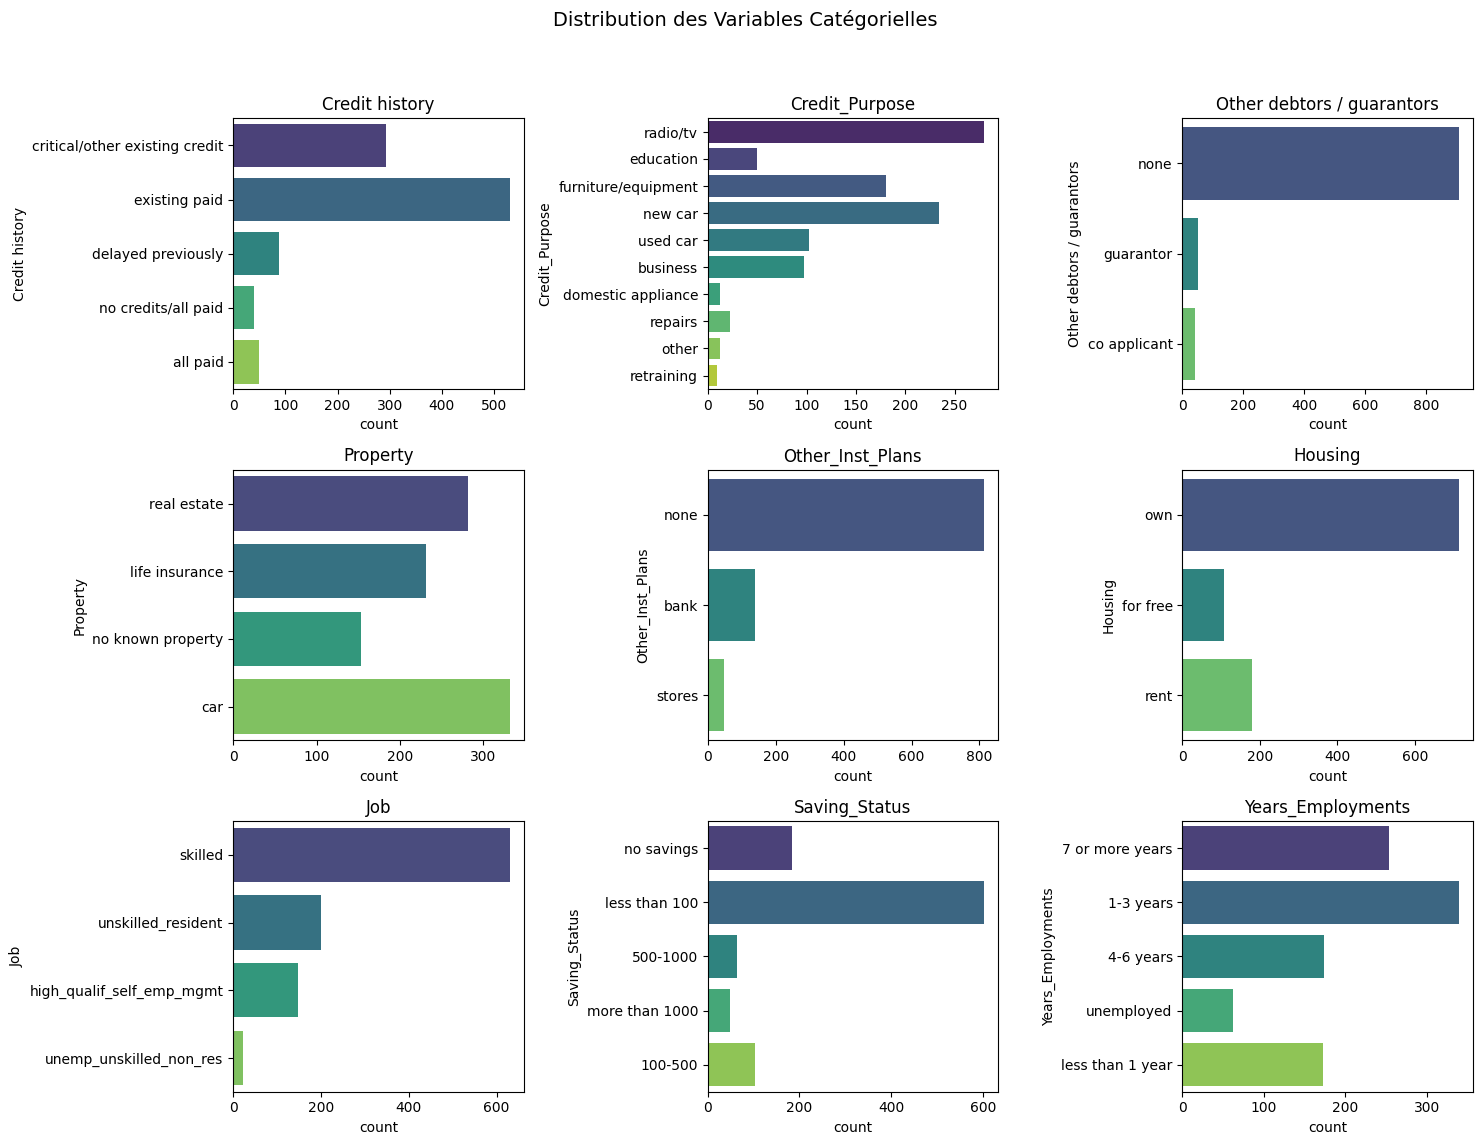

In [ ]:
# Sélection des variables catégorielles (excluant la cible)
cat_vars = ["Credit history", "Credit_Purpose", "Other debtors / guarantors", "Property", "Other_Inst_Plans",
            "Housing", "Job", "Saving_Status", "Years_Employments"]

# Affichage des distributions des variables catégorielles
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Distribution des Variables Catégorielles", fontsize=14)

for i, var in enumerate(cat_vars):
    sns.countplot(y=df[var], palette="viridis", ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(var)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


- Le status et Le Genre (Gender)

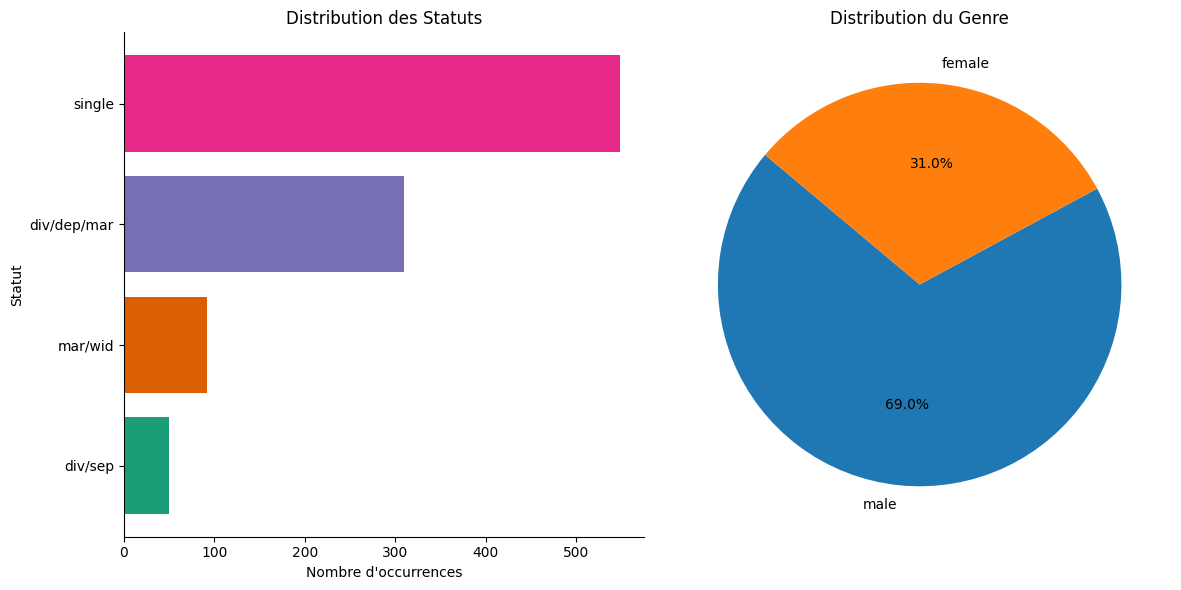

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Premier graphique : Distribution des Statuts (Barres horizontales)
status_counts = df['Status'].value_counts(ascending=True)
axes[0].barh(status_counts.index, status_counts.values, color=sns.color_palette('Dark2', len(status_counts)))
axes[0].set_title("Distribution des Statuts")
axes[0].set_xlabel("Nombre d'occurrences")
axes[0].set_ylabel("Statut")
axes[0].spines[['top', 'right']].set_visible(False)  # Supprimer les bordures inutiles

# Deuxième graphique : Distribution du Genre (Camembert)
gender_counts = df['Gender'].value_counts()
axes[1].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title("Distribution du Genre")

# Affichage des graphiques côte à côte
plt.tight_layout()
plt.show()


**Distribution de status(matrimoniale)**
- la catégorie "single" (célibataire) est la plus fréquente avec le plus grand nombre d'occurrences (548).
- la catégorie "div/dep/mar" (divorcé, séparé, marié) suit en termes de fréquences(310).
- "mar/wid" (marié/veuf) 92 et "div/sep" (divorcé/séparé) 50 sont beaucoup moins représenté dans notre échantillon.

**Distribution du genre (sexe)**
- 69% des individus sont de sexe masculin("male")
- 31% des individus sont de sexe féminin("female").

La population analysée contient en majorité les individus de sexe masculin.
Le statut matrimonial majoritaire est "single" célibataire, ce qui indique une population relativement jeune ou/avec une forte proportion de célibataire.  

-  Status (Situation matrimoniale)

In [ ]:
Job_counts = df['Job'].value_counts(ascending=True)

Credit_history_counts = df['Credit history'].value_counts(ascending=True)

Housing_counts = df['Housing'].value_counts(ascending=True)

Checking_Account_Status_counts = df['Checking_Account_Status'].value_counts(ascending=True)

Years_Employments_counts = df['Years_Employments'].value_counts(ascending=True)

Saving_Status_counts = df['Saving_Status'].value_counts(ascending=True)

Property_counts = df['Property'].value_counts(ascending=True)

# print(Job_counts)

#print(Credit_history_counts)

## **Analyse Bivarié**

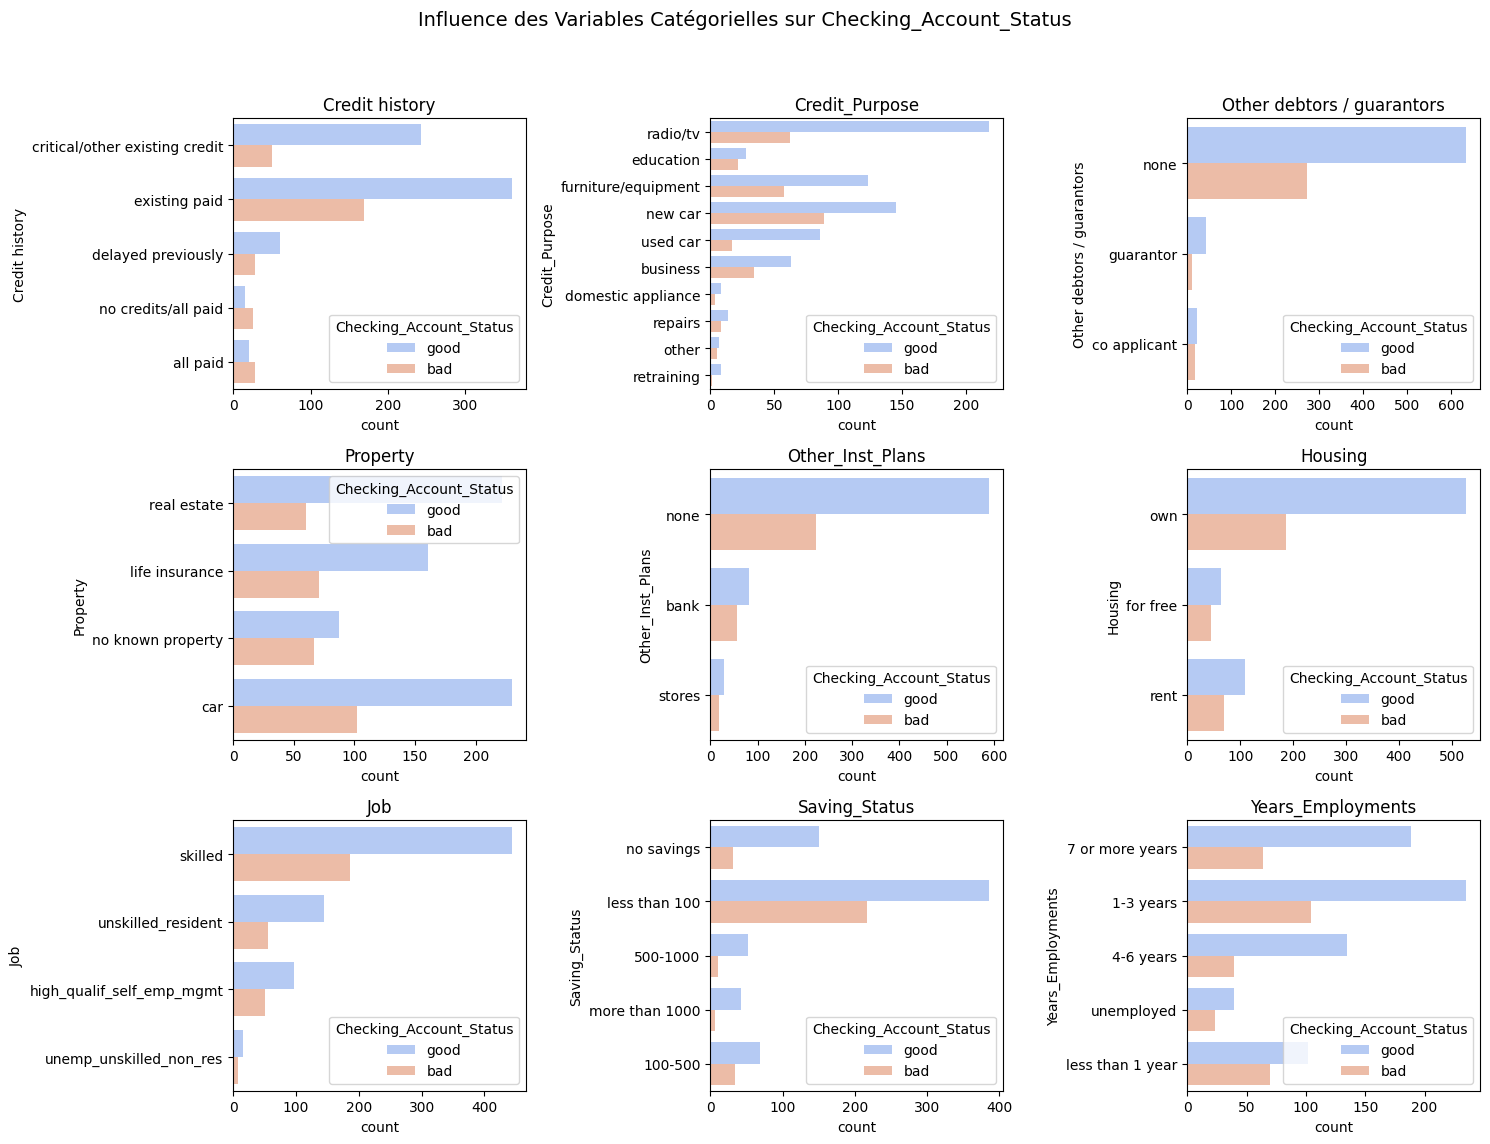

In [ ]:
# Analyse de l'influence des variables catégorielles sur la cible
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Influence des Variables Catégorielles sur Checking_Account_Status", fontsize=14)

for i, var in enumerate(cat_vars):
    sns.countplot(y=df[var], hue=df["Checking_Account_Status"], palette="coolwarm", ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(var)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


 - "Credit history" : Les clients ayant un historique critique ("critical/other existing credit") sont majoritairement classés "Bad".
 - "Credit Purpose" : Certains motifs de prêt (ex : nouvelle voiture, éducation) semblent plus associés aux clients "Bad" que d’autres.
 - "Other debtors/guarantors" : Les clients ayant un garant ont une répartition plus équilibrée entre "Good" et "Bad", contrairement à ceux sans garant.

- "Housing" : Les propriétaires semblent être moins à risque ("Good"), tandis que les locataires ont une proportion plus élevée de "Bad".

- "Years of Employment" : Les clients ayant peu d’expérience professionnelle (0-1 ans) ont une plus grande probabilité d’être "Bad".

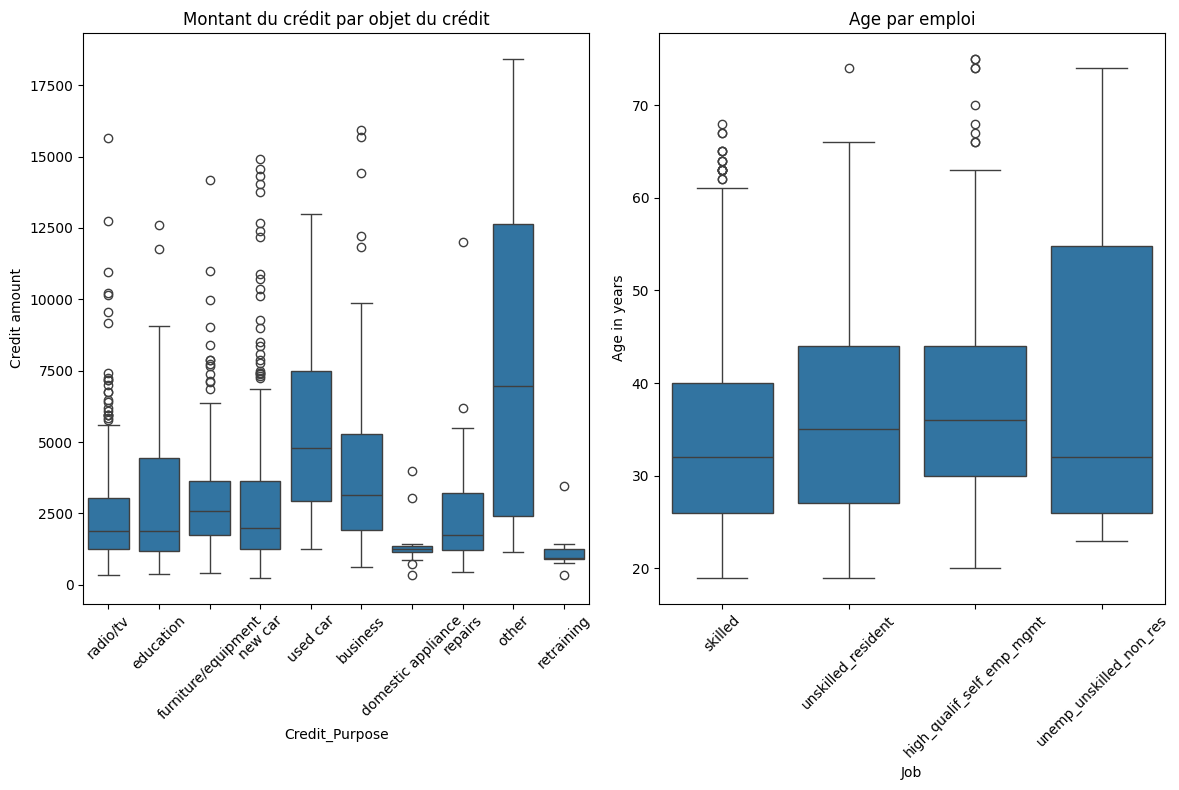

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x='Credit_Purpose', y='Credit amount', data=df)
plt.title('Montant du crédit par objet du crédit')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='Job', y='Age in years', data=df)
plt.title('Age par emploi')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Montant du crédit par objet du crédit**

On observe :
- Une forte variabilité du montant du crédit selon l'objectif.
- Les crédits les plus élevés semble être associés aux catégories *business* et *other*, qui présentent de grandes médianes et des valeurs extrêmes élevées.
- Certaines catégories comme *domestic appliance* et *retraining* ont des montants de crédit beaucoup plus faibles en moyenne.
- il y a de nombreux outliers (points en dehors des moustaches), indiquant qu'il existe quelques prêts très élevés par rapport à la majorité des observations.

**Âge par type d'emploi** (Graphique de droite)

- Les personnes dans la catégorie "unemp/unskilled non res" semblent être plus âgées en moyenne, avec une mediane plus haute et une forte dispersion des âges.
- Les "skilled workers et unskilled residents"  ont une distribution d'âge resserrée.
- Plusieurs outliers, en particulier pour les travailleurs qualifiés et les employés hautement qualifiés.

en somme:

Le montant du crédit accordés pour les affaires (business) et les autres (other) sont en moyenne plus élevés, tandis que ceux pour les appareils
domestiques et la formation sont plus faibles.

Les travailleurs non qualifiés ou au chômage semblent être plus âgés en moyenne, ce qui pourrait indiquer une plus grande difficulté d'accès à l'emploi pour les personnes plus âgées.


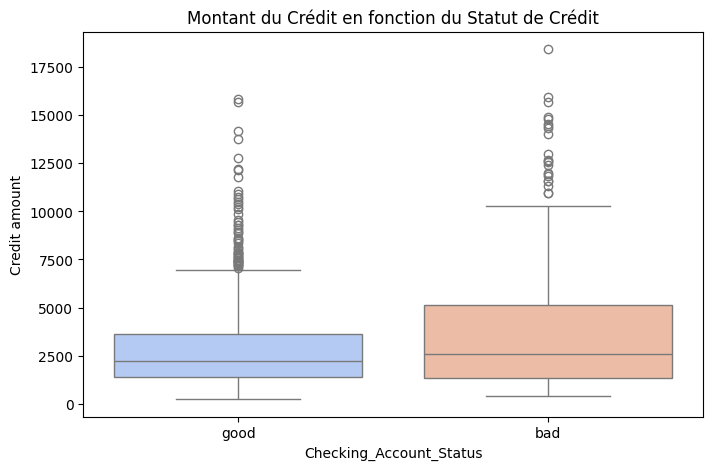

In [ ]:
# 1. Boxplot du montant du crédit par Checking_Account_Status
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Checking_Account_Status"], y=df["Credit amount"], palette="coolwarm")
plt.title("Montant du Crédit en fonction du Statut de Crédit")
plt.xlabel("Checking_Account_Status")
plt.ylabel("Credit amount")
plt.show()




Ce graphique montre un boxplot qui compare le montant du crédit en fonction du statut du compte courant.

- les individus ayant "good" ont une mediane de montant de crédit légèrement plus élevée que ceux ayant un statut "bad" cependant les distributions restent globalement proches.

- Les individus avec un statut de crédit "good" ont généralement accès à des montants de crédit plus élevés et plus variés
- tandis que les individus ayant le statut "bad" semblent plus restreints en termes de montant de prêt.

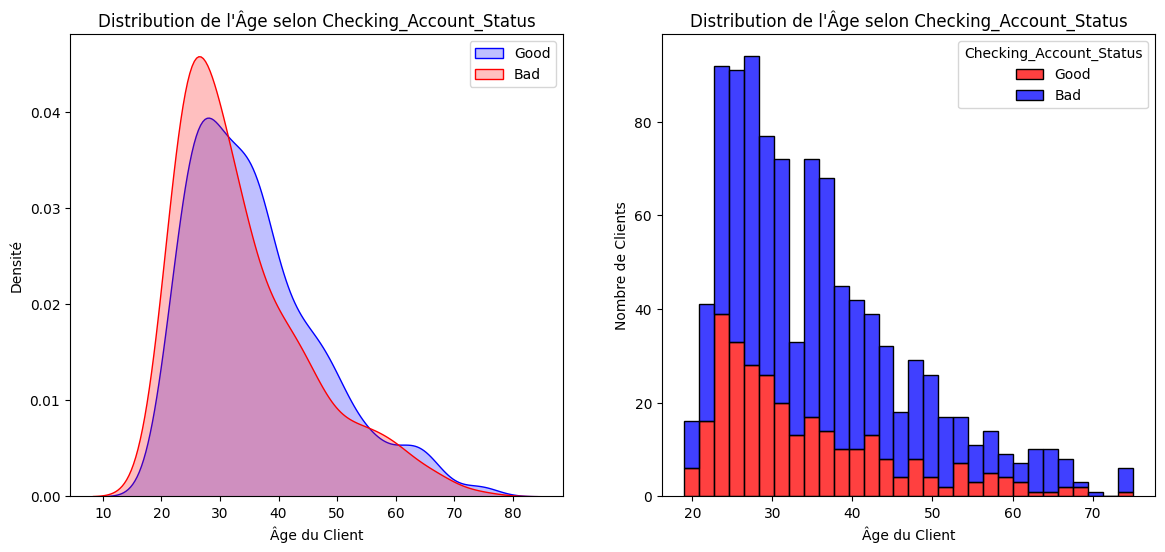

In [ ]:
# 2. Distribution de l'âge selon Checking_Account_Status (KDE Plot)

plt.figure(figsize=(14, 6))

#plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(df[df["Checking_Account_Status"] == "good"]["Age in years"], fill=True, label="Good", color="blue")
sns.kdeplot(df[df["Checking_Account_Status"] == "bad"]["Age in years"], fill=True, label="Bad", color="red")
plt.title("Distribution de l'Âge selon Checking_Account_Status")
plt.xlabel("Âge du Client")
plt.ylabel("Densité")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df, x="Age in years", hue="Checking_Account_Status", multiple="stack", bins=30, palette=["blue", "red"])
plt.title("Distribution de l'Âge selon Checking_Account_Status")
plt.xlabel("Âge du Client")
plt.ylabel("Nombre de Clients")
plt.legend(title="Checking_Account_Status", labels=["Good", "Bad"])

plt.show()

- La majorité des clients ont entre 20 et 50 ans.
- Les clients "Bad" sont plus présents entre 20 et 40 ans, ce qui pourrait indiquer un risque plus élevé pour les jeunes emprunteurs.
- Au-delà de 50 ans, la proportion de clients "Bad" diminue, suggérant que les emprunteurs plus âgés sont plus stables financièrement.

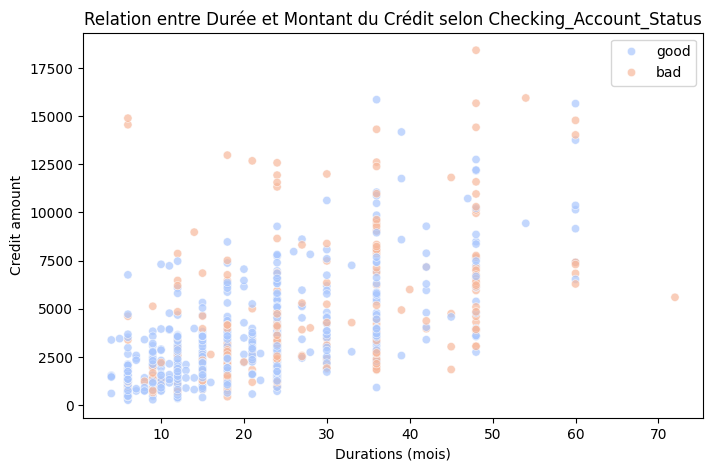

In [ ]:
# 4. Scatter plot entre "Credit amount" et "Durations" coloré par Checking_Account_Status
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Durations"], y=df["Credit amount"], hue=df["Checking_Account_Status"], palette="coolwarm", alpha=0.7)
plt.title("Relation entre Durée et Montant du Crédit selon Checking_Account_Status")
plt.xlabel("Durations (mois)")
plt.ylabel("Credit amount")
plt.legend()
plt.show()


**Relation entre Durée et Montant du Crédit selon Checking_Account_Status**  

On observe:
- une correlationn positive entre durée et montant du crédit (les crédits plus longs ont tendance à avoir des montants plus élevés, même si nous avons des crédits de courte durée avec des montants importants.)

- bonne repartition entre "good" et "bad" entre le credit compris entre 5 et 10 000 unités monétaires mais des crédits supérieur à 15k unités monétaires sont principalement en statut "good".

1. les crédits plus longs sont souvent associés à des montants plus élevés, probablement enn raison des capacités de remboursement.
2. Les emprunteurs avec un statut "bad" semblent limités en durée et montant, ce qui pourrait refléter des critères de risque bancaire stricts.


**Âge et Le montant du crédit.**

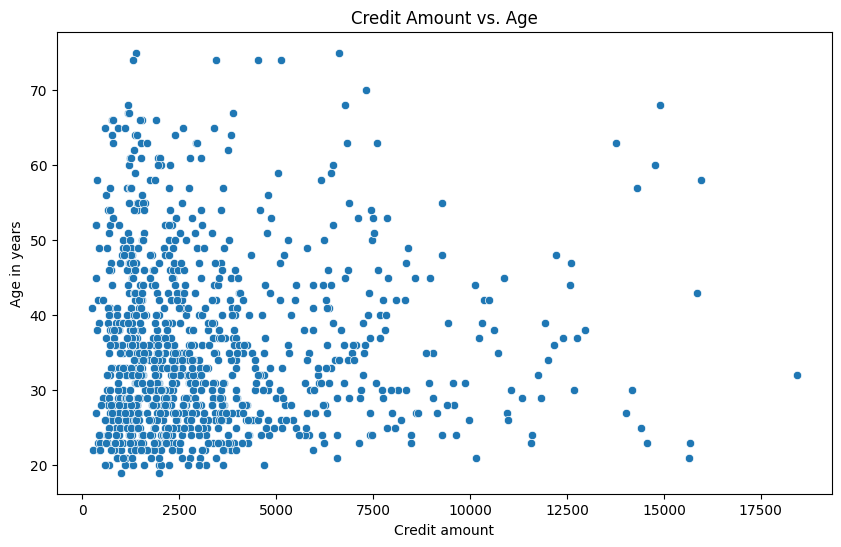

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Credit amount', y='Age in years', data=df)
plt.title('Credit Amount vs. Age')
plt.show()

- Les jeunes, adultes sont les principaux demandeurs de credits, avec une concentration importante autour de montants faibles.
- Les crédits élevés sont plus rares mais repartis sur différents groupes d'âges.
- Les personnes âgees semblent demander moins de crédits, ce qui peut être dû à une moindre nécessité d'emprunter ou à des restrictions bancaires

- **Corrélation**

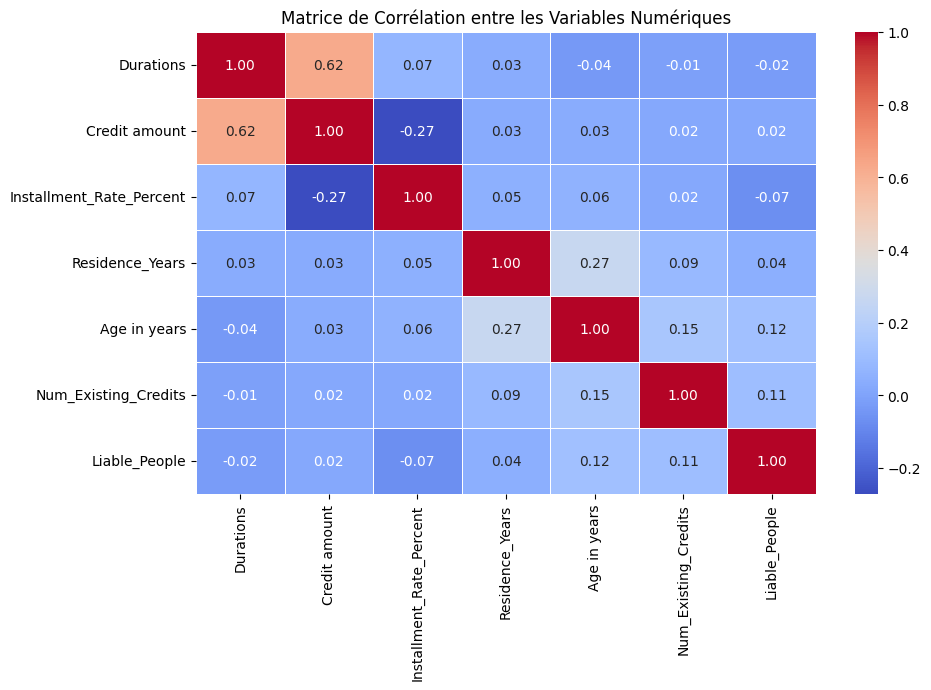

In [ ]:
# Matrice de corrélation pour les variables numériques
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation entre les Variables Numériques")
plt.show()

-  **Credit amount** et **Duration** ont une corrélation positive → Plus un prêt est long, plus son montant est élevé.

- **Age in years** n’a pas de forte corrélation avec les autres variables, ce qui suggère qu’il doit être analysé indépendamment.

- **Num_Existing_Credits** et **Residence_Years** ont une corrélation modérée,



# II - **Modélisation**

### 1- **Data preprocessing**

In [ ]:
#pip install joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

# Copier le dataset pour éviter de modifier l'original
df_prep = df.copy()


In [ ]:
df_prep.head()

,Durations,Credit history,Credit_Purpose,Credit amount,Installment_Rate_Percent,Other debtors / guarantors,Residence_Years,Property,Age in years,Other_Inst_Plans,...,Num_Existing_Credits,Job,Liable_People,Telephone,Foreign worker,Checking_Account_Status,Gender,Status,Years_Employments,Saving_Status
0,6,critical/other existing credit,radio/tv,1169,4,none,4,real estate,67,none,...,2,skilled,1,yes,yes,good,male,single,7 or more years,no savings
1,48,existing paid,radio/tv,5951,2,none,2,real estate,22,none,...,1,skilled,1,none,yes,bad,female,div/dep/mar,1-3 years,less than 100
2,12,critical/other existing credit,education,2096,2,none,3,real estate,49,none,...,1,unskilled_resident,2,none,yes,good,male,single,4-6 years,less than 100
3,42,existing paid,furniture/equipment,7882,2,guarantor,4,life insurance,45,none,...,1,skilled,2,none,yes,good,male,single,4-6 years,less than 100
4,24,delayed previously,new car,4870,3,none,4,no known property,53,none,...,2,skilled,2,none,yes,bad,male,single,1-3 years,less than 100


In [ ]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Durations                   1000 non-null   int64 
 1   Credit history              1000 non-null   object
 2   Credit_Purpose              1000 non-null   object
 3   Credit amount               1000 non-null   int64 
 4   Installment_Rate_Percent    1000 non-null   int64 
 5   Other debtors / guarantors  1000 non-null   object
 6   Residence_Years             1000 non-null   int64 
 7   Property                    1000 non-null   object
 8   Age in years                1000 non-null   int64 
 9   Other_Inst_Plans            1000 non-null   object
 10  Housing                     1000 non-null   object
 11  Num_Existing_Credits        1000 non-null   int64 
 12  Job                         1000 non-null   object
 13  Liable_People               1000 non-null   int64

In [ ]:
df_prep.select_dtypes(include=['object', 'category']).columns

Index(['Credit history', 'Credit_Purpose', 'Other debtors / guarantors',
       'Property', 'Other_Inst_Plans', 'Housing', 'Job', 'Telephone',
       'Foreign worker', 'Checking_Account_Status', 'Gender', 'Status',
       'Years_Employments', 'Saving_Status'],
      dtype='object')

In [ ]:
# Encodage de la variable cible (Checking_Account_Status : Good -> 0, Bad -> 1)
label_encoder = LabelEncoder()
df_prep["Checking_Account_Status"] = label_encoder.fit_transform(df_prep["Checking_Account_Status"])

# Séparation des variables numériques et catégorielles
num_features = ["Durations", "Credit amount", "Age in years", "Installment_Rate_Percent", "Residence_Years", "Num_Existing_Credits", "Liable_People"]
cat_features = ["Credit history", "Credit_Purpose", "Other debtors / guarantors","Property", "Other_Inst_Plans", "Housing", "Job", "Telephone",
                "Foreign worker", "Gender", "Status", "Years_Employments", "Saving_Status"]

# Appliquer une transformation log sur "Credit amount" pour réduire l'impact des valeurs extrêmes
df_prep["Credit amount"] = np.log1p(df_prep["Credit amount"])

# Normalisation des variables numériques
scaler = StandardScaler()
df_prep[num_features] = scaler.fit_transform(df_prep[num_features])

# Encodage One-Hot des variables catégorielles
df_prep = pd.get_dummies(df_prep, columns=cat_features, drop_first=True)



In [ ]:
# Séparation des variables X et de la cible y
X = df_prep.drop(columns=["Checking_Account_Status"])
y = df_prep["Checking_Account_Status"]

train_df_prep , test_df_prep = train_test_split(df_prep,test_size=0.2,random_state = 42)

In [ ]:
# Préparation des données d'entraînement et de test
X_train = train_df_prep.drop(columns=["Checking_Account_Status"])
y_train = train_df_prep["Checking_Account_Status"]
X_test = test_df_prep.drop(columns=["Checking_Account_Status"])
y_test = test_df_prep["Checking_Account_Status"]

In [ ]:
X_train

,Durations,Credit amount,Installment_Rate_Percent,Residence_Years,Age in years,Num_Existing_Credits,Liable_People,Telephone,Foreign worker,Gender,...,Job_unemp_unskilled_non_res,Job_unskilled_resident,Saving_Status_500-1000,Saving_Status_less than 100,Saving_Status_more than 1000,Saving_Status_no savings,Years_Employments_4-6 years,Years_Employments_7 or more years,Years_Employments_less than 1 year,Years_Employments_unemployed
29,3.243815,1.341858,0.024147,1.046987,2.414647,1.027079,-0.428290,yes,yes,male,...,False,False,False,True,False,False,False,True,False,False
535,0.008048,-0.051466,-0.870183,-1.672459,-0.223927,-0.704926,-0.428290,none,yes,male,...,False,False,False,True,False,False,False,False,True,False
695,-1.236478,-0.862203,-0.870183,1.046987,1.271265,-0.704926,-0.428290,none,yes,male,...,False,False,True,False,False,False,False,False,False,False
557,0.008048,0.939490,-1.764514,1.046987,-0.575737,1.027079,-0.428290,yes,yes,female,...,False,False,False,False,False,True,False,False,False,False
836,-0.738668,-1.290984,0.918477,-0.765977,-1.279356,-0.704926,-0.428290,none,yes,female,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-0.240857,1.268536,-0.870183,1.046987,0.303788,1.027079,2.334869,yes,yes,male,...,False,False,False,True,False,False,False,True,False,False
270,-0.240857,0.126294,0.918477,0.140505,-0.311879,-0.704926,-0.428290,none,no,male,...,False,False,False,False,False,True,True,False,False,False
860,0.256953,1.130910,0.918477,-0.765977,-0.751642,1.027079,-0.428290,none,yes,male,...,False,False,False,False,True,False,False,False,False,False
435,-0.738668,-0.626637,-0.870183,-1.672459,-0.927547,-0.704926,-0.428290,yes,yes,male,...,False,False,False,False,False,True,False,False,False,False


### 2 - **Modélisation**

**Regression logistique**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Création du modèle de régression logistique
log_reg = LogisticRegression()

# Entraînement du modèle
log_reg.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = log_reg.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)


Accuracy: 0.745
Confusion Matrix:
 [[ 23  36]
 [ 15 126]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.39      0.47        59
           1       0.78      0.89      0.83       141

    accuracy                           0.74       200
   macro avg       0.69      0.64      0.65       200
weighted avg       0.73      0.74      0.73       200



**Random Forest**

In [ ]:
# Création et entraînement du modèle Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_rf = random_forest.predict(X_test)

# Évaluation du modèle Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)
print("Confusion Matrix:\n", conf_matrix_rf)
print("Classification Report:\n", report_rf)


Random Forest Accuracy: 0.725
Confusion Matrix:
 [[ 17  42]
 [ 13 128]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.29      0.38        59
           1       0.75      0.91      0.82       141

    accuracy                           0.72       200
   macro avg       0.66      0.60      0.60       200
weighted avg       0.70      0.72      0.69       200



**Arbre de decision**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Création et entraînement du modèle Arbre de Décision
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_dt = decision_tree.predict(X_test)

# Évaluation du modèle Arbre de Décision
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree Accuracy:", accuracy_dt)
print("Confusion Matrix:\n", conf_matrix_dt)
print("Classification Report:\n", report_dt)


Decision Tree Accuracy: 0.63
Confusion Matrix:
 [[ 23  36]
 [ 38 103]]
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.39      0.38        59
           1       0.74      0.73      0.74       141

    accuracy                           0.63       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.63      0.63      0.63       200



**XGBOOST**

In [ ]:
import xgboost as xgb

# Création et entraînement du modèle XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation du modèle XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print("XGBoost Accuracy:", accuracy_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)
print("Classification Report:\n", report_xgb)


XGBoost Accuracy: 0.765
Confusion Matrix:
 [[ 26  33]
 [ 14 127]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.44      0.53        59
           1       0.79      0.90      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



**Evaluation des Modèles**

In [ ]:
import pandas as pd
from tabulate import tabulate

# Créer un dictionnaire avec les données
data = {
    "Modèle": ["Régression Logistique", "Random Forest", "Arbre de Décision", "XGBoost"],
    "Accuracy": ["74.5%", "72.5%", "63.0%", "76.5%"],
    "Precision Classe 0": [0.61, 0.57, 0.38, 0.65],
    "Recall Classe 0": [0.39, 0.29, 0.39, 0.44],
    "F1-Score Classe 0": [0.47, 0.38, 0.38, 0.53],
    "Precision Classe 1": [0.78, 0.75, 0.74, 0.79],
    "Recall Classe 1": [0.89, 0.91, 0.73, 0.90],
    "F1-Score Classe 1": [0.83, 0.82, 0.74, 0.84],
    "Macro Avg F1-Score": [0.65, 0.60, 0.56, 0.68],
    "Weighted Avg F1-Score": [0.73, 0.69, 0.63, 0.75]
}

# Créer un DataFrame à partir du dictionnaire
tab = pd.DataFrame(data)

# Utiliser tabulate pour afficher le tableau
#print(tabulate(df, headers='keys', tablefmt='pipe', showindex=False))


In [ ]:
tab

,Modèle,Accuracy,Precision Classe 0,Recall Classe 0,F1-Score Classe 0,Precision Classe 1,Recall Classe 1,F1-Score Classe 1,Macro Avg F1-Score,Weighted Avg F1-Score
0,Régression Logistique,74.5%,0.61,0.39,0.47,0.78,0.89,0.83,0.65,0.73
1,Random Forest,72.5%,0.57,0.29,0.38,0.75,0.91,0.82,0.60,0.69
2,Arbre de Décision,63.0%,0.38,0.39,0.38,0.74,0.73,0.74,0.56,0.63
3,XGBoost,76.5%,0.65,0.44,0.53,0.79,0.90,0.84,0.68,0.75


In [ ]:

#modeles = ["Régression Logistique", "Random Forest", "Arbre de Décision", "XGBoost"]
#Precision_globale = [74.5, 72.5, 63.0, 76.5]  # Précisions en pourcentage comme fournies précédemment

# Création du graphique à barres
#plt.figure(figsize=(8, 5))
#plt.bar(modeles, Precision_globale, color=['blue', 'green', 'red', 'purple'])
#plt.xlabel('Modèles')
#plt.ylabel('Précision (%)')
#plt.title('Précision Globale des Modèles')
#plt.ylim([50, 80])  # Ajuster selon les valeurs maximales et minimales pour une meilleure visibilité
#plt.show()


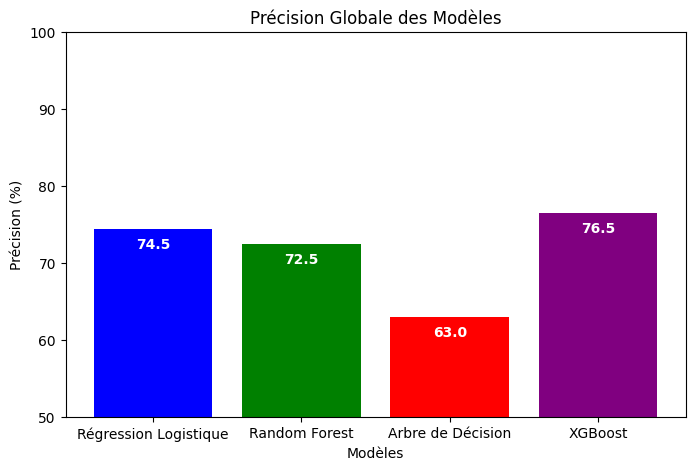

In [ ]:
import matplotlib.pyplot as plt

# Données pour la visualisation
models = ["Régression Logistique", "Random Forest", "Arbre de Décision", "XGBoost"]
accuracies = [74.5, 72.5, 63.0, 76.5]  # Précisions en pourcentage comme fournies précédemment

# Création du graphique à barres
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])

# Ajout des labels sur les barres
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 3, round(accuracy, 1), ha='center', va='bottom', color='white', weight='bold')

plt.xlabel('Modèles')
plt.ylabel('Précision (%)')
plt.title('Précision Globale des Modèles')
plt.ylim([50, 100])  # Étendu pour mieux visualiser les textes sur les barres
plt.show()




**XGBoost**  montre la meilleure performance globale avec une précision de 76.5%.

**Régression Logistique** suit de près avec une précision de 74.5%.

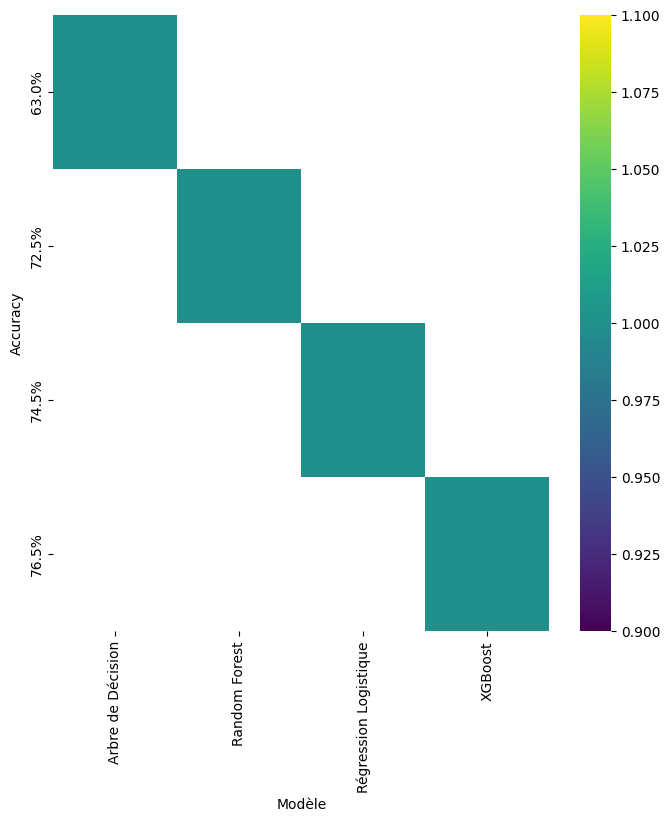

In [ ]:
# @title Modèle vs Accuracy

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Accuracy'].value_counts()
    for x_label, grp in tab.groupby('Modèle')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Modèle')
_ = plt.ylabel('Accuracy')

**Régression Logistique**:
Accuracy: 74.5%
Recall pour la classe 1: 89%
Les performances sont correctes, mais le rappel pour la classe 0 est assez faible (39%).

**Random Forest**:
Accuracy: 72.5%
Recall pour la classe 1: 91%
Légèrement inférieur à la régression logistique en termes d'exactitude globale. La précision pour la classe 0 est également faible.

**Arbre de Décision**:
Accuracy: 63%
Recall pour la classe 1: 73%
Le moins performant des quatre modèles. Présente des problèmes de surajustement typiques aux arbres de décision, avec un faible rappel et une faible précision pour la classe 0.

**XGBoost:**
Accuracy: 76.5%
Recall pour la classe 1: 90%
Le meilleur modèle en termes d'exactitude globale et de gestion des deux classes. Cela montre une bonne balance entre le rappel et la précision pour la classe majoritaire et minoritaire.

### Sauvrgarde du modèles XGBoost

In [ ]:
from joblib import dump, load

# Sauvegarder un modèle
dump(xgb_model, 'xgboost_model.joblib')

['xgboost_model.joblib']

**test**

In [ ]:
# Charger un modèle
loaded_xgb_model = load('xgboost_model.joblib')

In [ ]:

# Pour faire une prédiction avec le modèle chargé XGBoost
y_pred_xgb1 = loaded_xgb_model.predict(X_test)


In [ ]:
#y_pred_xgb1

In [ ]:
#Évaluation du modèle XGBoost
#accuracy_xgb1 = accuracy_score(y_test, y_pred_xgb1)
#conf_matrix_xgb1 = confusion_matrix(y_test, y_pred_xgb1)
#report_xgb1 = classification_report(y_test, y_pred_xgb1)

#print("XGBoost Accuracy:", accuracy_xgb)
#print("Confusion Matrix:\n", conf_matrix_xgb)
#print("Classification Report:\n", report_xgb)


#print("XGBoost Accuracy:", accuracy_xgb1)
#print("Confusion Matrix:\n", conf_matrix_xgb1)
#print("Classification Report:\n", report_xgb1)